In [5]:
from __future__ import division
import os
import csv
import pysam
import math

import subprocess
import commands
import gzip
import glob
import math
import pandas as pd
import numpy as np
import matplotlib as plt
from pyveplot import *
#from collections import namedtuple
import networkx as nx
import random
from IPython.display import SVG
%matplotlib inline

## Circos vs Hiveplots

This notebook attemps to find alternative, clearer plots for inter and intra-chromosomal structural variations. In other words, the idea is to go from

A typical Circos plot:

<img src="https://www.genomatix.de/online_help/help_regionminer/SV_circos_genome.png" height=300 width=300/>

To this:

<img src="img/hyplot_intra_inter.png"/>

From this:

<img src="img/sv_table.png"/>

Some of the preliminary data comes from [Australian Pancreatic Cancer Genome Initiative](http://www.pancreaticcancer.net.au/), other from the [ICGC-TCGA DREAM challenge](https://www.synapse.org/#!Synapse:syn312572) processed via the [bcbio cancer pipeline](https://bcbio-nextgen.readthedocs.org/en/latest/contents/pipelines.html#cancer-variant-calling). That pipeline run takes a considerable amount of time to run given the big input sizes and [running several variant callers](http://bcb.io/2015/03/05/cancerval/).

For pedagogical reasons, the resulting tab-separated `.tsv` files have been generated for easy analysis. If a more upstream run or (re)-analysis  is required, there's [reduced dataset that focuses on chromosome 6](https://bcbio-nextgen.readthedocs.org/en/latest/contents/teaching.html).

After filtering VCF's resulting from both [Manta](https://github.com/Illumina/manta) variant caller and [Lumpy](https://github.com/arq5x/lumpy-sv) with a simple [vawk expression](https://github.com/cc2qe/vawk):

<pre>
gzcat manta-variants.vcf.gz | vawk '{{if (($12 == "PASS")) print $1, $4, $11, $17 }}'
</pre>

A svtools script, [`vcfToBedpe`](https://raw.githubusercontent.com/hall-lab/svtools/master/bin/vcftobedpe), was used to convert a plain [VCF](https://samtools.github.io/hts-specs/VCFv4.2.pdf) to [BEDPE format](http://bedtools.readthedocs.org/en/latest/content/general-usage.html#bedpe-format) to generate a paired end version where structural variations are seen as pairs (`chrom` and `chrom_b` columns).

Finally, [pyveplot](https://github.com/CSB-IG/pyveplot), a Python implementation of [Hive plots](http://www.hiveplot.net/) was used to show the representation above.

A Hive plot is a perceptually uniform and scalable linear layout visualization for network visual analytics (doi: 10.1093/bib/bbr069).

<img src="img/hiveplot-thisisuseful.png"/>

In [6]:
vcf_data = "data/vcf"
tsv_data = "data/tsv"
ev_data = "data/sv_size"

lorena_vcf = "data/lorena_vcf"
lorena_tsv = "data/lorena_tsv"

brad_vcf = "data/bradsv/input"
brad_csv = "data/bradsv/sv_plots"

bnd_genotype_vcf = "data/bndgenotype/input"
bnd_genotype_csv = "data/bndgenotype/sv_plots"

ohoffman_vcf = "data/ohoffman_brain/input"
ohoffman_csv = "data/bndgenotype/sv_plots"

icgc_vcf = "data/icgc/sv_plots"
icgc_csv = "data/icgc/sv_plots"

event_colors = {'DEL': 'red',
                'INV': 'yellow',
                'DUP': 'blue',
                'BND': 'green',
                'complex': 'purple'}

# handy mapping

#Unstable: APGI 1953 (ICGC 0006)
#Focal: APGI 1955 (ICGC 0007)
#Stable: APGI 2049 (ICGC 0031)

sample_class = { 'APGI1953_Tumor': 'Unstable (APGI1953)',
                 'APGI1955_Tumor': 'Focal (APGI1955)',
                 'APGI2049_Tumor': 'Stable (APGI2094)'}

In [7]:
#!/usr/bin/env python
"""Extract structural variations in regions of interest into tab delimited files for circos plots.
"""

def prepare_samples():
    samples = {"APGI": ["APGI1953_Tumor", "APGI1955_Tumor", "APGI2049_Tumor"]}
    callers = ["lumpy"]
    chroms = {"APGI": [x for x in range(1, 23)]}

    allowed_chroms = set([str(x) for x in range(1, 23)])
    for project, samples in samples.items():
        out_file = "%s-svs.csv" % (project)
        region_bed = "%s-ends.bed" % (project)
        with open(out_file, "w") as out_handle:
            with open(region_bed, "w") as region_out:
                writer = csv.writer(out_handle)
                writer.writerow(["chrom1", "start1", "end1", "chrom2", "start2", "end2", "sample", "caller", "svtype"])
                for sample in samples:
                    for ci, caller in enumerate(callers):
                        sv_file = "%s-%s.vcf.gz" % (sample, caller)
                        for p1, p2, svtype in parse_svs(sv_file):
                            if True:
                            #if p1[0] in chroms[project] or p2[0] in chroms[project]:
                                if p1[0] in allowed_chroms and p2[0] in allowed_chroms:
                                    writer.writerow(p1 + p2 + [sample, caller, svtype])
                                    if ci == 0:
                                        for (chrom, start, end) in [p1, p2]:
                                            region_out.write("%s\t%s\t%s\t%s\n" % (chrom, start - 1, end, sample))
        filter_shared(out_file, region_bed)
        # noshared_file = "%s-noshared%s" % os.path.splitext(out_file)
        # with open(noshared_file, "w") as out_handle:
        #     writer = csv.writer(out_handle)
        #     writer.writerow(["chrom1", "start1", "end1", "chrom2", "start2", "end2", "sample", "caller", "svtype"])
        #     for row in filter_shared(out_file, region_bed):
        #         writer.writerow(row)

def filter_shared(in_file, region_bed):
    #http://stackoverflow.com/questions/4265284/how-to-do-sort-v-in-osx
    cmd = "sort -k1,1 -k2,2n {region_bed} | bedtools merge -i - -d 10000 -c 4 -o count_distinct"
    overlaps = subprocess.check_output(cmd.format(**locals()), shell=True)
    shared = 0
    noshared = 0
    for line in overlaps.split("\n"):
        if line.strip():
            if int(line.strip().split()[-1]) > 1:
                shared += 1
            else:
                noshared += 1
    print shared, noshared
    return []

def parse_svs(in_file):
    bnds = {}

    min_su_bnd = 25
    min_su_other = 25

    for rec in pysam.VariantFile(in_file):
        if passes(rec):
            if rec.info["SVTYPE"] == "BND":
                if rec.info.get("SU") is None or rec.info["SU"] > min_su_bnd:
                    p = [rec.chrom.replace("chr", ""), rec.start, rec.start]
                    if rec.id in bnds:
                        p_o = bnds[rec.id]
                        yield p_o, p, rec.info["SVTYPE"]
                        del bnds[rec.id]
                    else:
                        mate_id = rec.info.get("MATEID")
                        bnds[mate_id] = p
            else:
                if rec.info.get("SU") is None or rec.info["SU"] > min_su_other:
                    p1 = [rec.chrom.replace("chr", ""), rec.start, rec.start]
                    p2 = [rec.chrom.replace("chr", ""), rec.info["END"], rec.info["END"]]
                    yield p1, p2, rec.info["SVTYPE"]

def passes(rec):
    if len(rec.filter.keys()) == 0 or rec.filter.keys() == 0 or rec.filter.keys()[0] == "PASS":
        if not rec.samples[0].get("GT"):
            return True
        elif list(set(rec.samples[0].get("GT"))) != ["N"]:
            return True
    return False

## Plot a hiveplot

In [8]:
def hiveplot(samples):
    """ Plots a hiveplot with:
            1) A lower quadrant axis dedicated to intra-chromosomal events.
            2) Right hand side axis represents inter-chromosomal events.
            3) Upper left corner reserved for kataegis events (still to be defined).
            
        :samples: An array containing tuples in the form: [(dataframe, sample_name), (dataframe2, sample2), ...]
    """
    axis_length = 200
    chroms = 23
    offset = math.ceil(axis_length/chroms)
   
    for dataframe, fname in samples:
        # Remove duplicates and filter out ALTS (GL000226.1, GL000224.1 ...)
        #dataframe = dataframe[~dataframe["chrom"].str.contains("GL")]
        dataframe = dataframe.drop_duplicates(keep="first") ## XXX: Perhaps should group/count dups better?

        # a network
        g = nx.Graph()

        # our hiveplot object
        h = Hiveplot('{}.svg'.format(fname))

                      # start      end
        axis0 = Axis((axis_length, axis_length), (axis_length, 100), stroke="grey")
        axis1 = Axis((axis_length, axis_length), (300,300), stroke="blue", stroke_width=1.2)
        axis2 = Axis((axis_length, axis_length), (10,310), stroke="black", stroke_width=3)

        
        h.axes = [ axis0, axis1, axis2 ]

        #print "Structural variation events for ''{fname}'' have the following counts:\n\n{groupby}\n".format(
        #       groupby=dataframe.groupby("sv").count(), fname=fname)

        for row in dataframe.itertuples():
            # idx, u'sample', u'chrom', u'chrom_b', u'sv', u'counts'
            g.add_node(row[2])
            # Count = 1 looks better than parametrized with groupby
            g.add_edge(row[2], row[3], event=row[4], count=1)

        try:
            for n in g.nodes():
                # XXX: skip X an y chromosomes for now
                # Separate instances for the axis, otherwise arcs go to itself.
                node = Node(n)
                node2 = Node(n)
                node3 = Node(n)

                node_offset = (offset*int(n))/axis_length
                print(node_offset)

                axis0.add_node(node, node_offset)
                axis1.add_node(node2, node_offset)
                axis2.add_node(node3, node_offset)
        except:
            continue
            #print("{chrom} will not be plotted".format(chrom=n))

        
        for e in g.edges():
            edge_data = g.get_edge_data(*e)

            # inter-chromosomal axis
            if e[0] != e[1] and (e[0] in axis0.nodes) and (e[1] in axis1.nodes):
                h.connect(axis0, e[0], 45, 
                          axis1, e[1], -45, 
                          stroke_width=edge_data['count'], 
                          stroke=event_colors[edge_data['event']])

            # intra-chromosomal axis
            elif e[0] == e[1] and (e[0] in axis1.nodes) and (e[1] in axis2.nodes):
                h.connect(axis1, e[0], 15, 
                          axis2, e[1], -15, 
                          stroke_width=edge_data['count'], 
                          stroke=event_colors[edge_data['event']])

        h.save()

### Shipped TSV's do not have the same structure, normalize

In [9]:
def normalize(data):
    """ Try to harmonize the different input csv/tsv files from different scripts
    """
    #print(data)
    if "chrom1" in data.columns:
        print(data.columns)
    #    print(data)
    #if "counts" not in data.columns:
    #    data.columns = ["chrom", "chrom_b", "sv"]
    #    data.insert(0, 'sample', np.nan)
    #    data.insert(len(data.columns), 'counts', np.nan)
    #else:
    #    data.insert(2, 'chrom_b', 0)

    # Cleanup GL* alts
    #data = data[~data["chrom"].str.contains("GL")]
    
    return data

In [10]:
def vcftobedpe_vawk(fnames_path, out_tsv_path=tsv_data, pass_filter=True):
    """ Converts a VCF file to paired end breakend BED file. Then filters via a specific vawk criteria.
    """
    
    for tumor in glob.iglob(os.path.join(fnames_path, "*.vcf.gz")):
        # already converted to bedpe
        if 'paired' in tumor:
            continue
        base_tumor_fn = os.path.splitext(os.path.splitext(tumor)[0]) 
        paired_fn = base_tumor_fn[0]+".paired"+".vcf"
        final_tsv = os.path.join(out_tsv_path, os.path.basename(base_tumor_fn[0])+".tsv")

        print("Converting filename {tumor} to {tsv}".format(tumor=tumor, tsv=final_tsv))
        vcftope_cmd = (["vcftobedpe", "-i", tumor, "-o", paired_fn])

        if not pass_filter:
            vawk_cmd = """gzcat {tumor} | grep -v ^GL | vawk '{{print $1,$4,$11}}' > {paired}""".format(tumor=tumor, paired=paired_fn)
            print vawk_cmd
        else:
            vawk_cmd = """gzcat {tumor} | grep -v ^GL | vawk \
                         '{{if (($12 == "PASS" || $7 == ".") && (S$GT != "0/0")) \
                          print $1,$4,$11}}' > {paired}""".format(tumor=tumor, paired=paired_fn)


        #vawk_sv_size = """cat {paired_vcf} | grep -v ^GL | vawk '{{if (($12 == "PASS" || $7 == ".") \
        #                  && (S$GT != "0/0") && (S$SR > 5)) \
        #                  print $1,$2,$4,$5,$11}}' > {tumor_tsv}""".format(paired_vcf=paired_fn, tumor_tsv=final_tsv)

        subprocess.check_call(vcftope_cmd)
        commands.getstatus(vawk_cmd)
        #commands.getstatus(vawk_sv_size)

In [11]:
def sample_summary_table(datasets):
    """ A table with chr1-Y as rows, each sample as a column, 
        number of inter/intra-chromosomal events as data points.

        :datasets: a tuple with several (data, sample_names) where data is the associated Pandas dataframe.
    """
    chromosomes = [str(x) for x in range(1,23)]
    chromosomes.append('X')
    chromosomes.append('Y')
    
    samples = [x[1] for x in datasets]
    
    summary = pd.DataFrame(columns=samples, index=chromosomes)
    
    for data, sample in datasets:
        # Uncomment and tweak code below if one wants totals, not by chromosome
        #intra_chrom = len(data[data['chrom'] == data['chrom_b']].index)
        #inter_chrom = len(data[data['chrom'] != data['chrom_b']].index)
        
        for chrom in chromosomes:
            intra_specific_chrom = len(data[((data['chrom'] == chrom) | (data['chrom_b'] == chrom)) & (data['chrom'] == data['chrom_b'])].index)
            inter_specific_chrom = len(data[((data['chrom'] == chrom) | (data['chrom_b'] == chrom)) & (data['chrom'] != data['chrom_b'])].index)
            
            summary.loc[chrom][sample] = (intra_specific_chrom, inter_specific_chrom)
        
        #print data.groupby(['sv', 'chrom'])['chrom'].count()
        
    return summary

In [12]:
def event_size_distr(dataset):
    """Can you get the size distribution of events out of the VCF (for the intrachromosomal SVs only)? 
       Wonder if this is Lumpy calling tons of short to mid-sized Indels. 
    """
    df = pd.read_table(dataset, dtype=object, names = ["chrom_a", "pos_a", "chrom_b", "pos_b", "sv"])
    # Only intra-chromosomal, positions between distant chroms can be misleading
    df = df[df['chrom_a'] == df['chrom_b']]
    df["size"] = abs(np.int64(df["pos_b"]) - np.int64(df["pos_a"]))
    #size_distr = df.groupby(['sv', 'chrom_a'])['size']

    return df

### Process and plot all the TSV's

In [15]:
def process_samples(vcf_files, out_tsv, pass_filter):
    samples = []
   
    #vcftobedpe_vawk(vcf_files, out_tsv, pass_filter)

    for dataset in glob.iglob(os.path.join(out_tsv, "*.?sv")):
        dataset_name = os.path.basename(dataset)

        if "tsv" in dataset_name:
            study = pd.read_table(dataset, dtype=object)
        elif "csv" in dataset_name:
            study = pd.read_csv(dataset, dtype=object)
        #study = normalize(study)
        
        samples.append((study, dataset_name))
        
    return samples

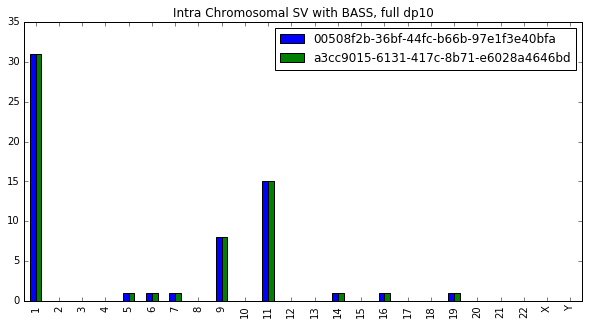

In [30]:
#samples = process_samples(lorena_vcf, lorena_tsv, pass_filter=False)
samples = process_samples(icgc_vcf, icgc_csv, pass_filter=False)
chrom_svs = samples[0][0][['sample', 'chrom1', 'chrom2', 'svtype']]
chrom_svs.columns = ['sample', 'chrom', 'chrom_b', 'sv']

tumors = []

for sample in chrom_svs.groupby("sample"):
    if 'APGI' in sample[0]:
        tumor_df = pd.DataFrame.copy(sample[1].replace(to_replace=sample_class))
        tumor_names = sample[0].replace(sample[0], sample_class[sample[0]])
        tumors.append((tumor_df, tumor_names))
    else:
        tumors.append((sample[1], sample[0]))

#hiveplot(chrom_svs)
#sample_summary_table(tumors).to_excel("New_APGI_Tumors_manta_with_Brad_script.xls")
#chrom_svs[0][0].groupby('sv')['sv'].count()
#chrom_svs
sample_summary_table(tumors).applymap(lambda x: x[0]).plot(kind="bar", figsize=(10, 5), title="Intra Chromosomal SV with {caller}, full dp10".format(caller='BASS'))

In [26]:
sample_summary_table(tumors).applymap(lambda x: x[0])

,00508f2b-36bf-44fc-b66b-97e1f3e40bfa,a3cc9015-6131-417c-8b71-e6028a4646bd
1,31,31
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,1
8,0,0
9,8,8
10,0,0


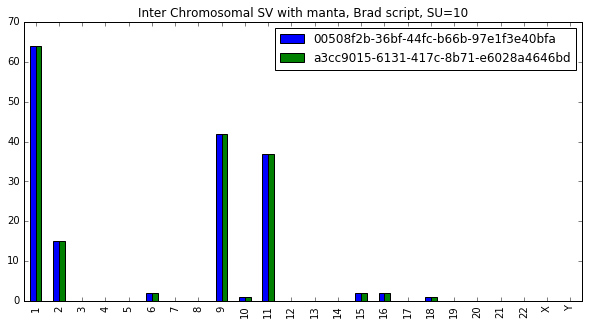

In [27]:
sample_summary_table(tumors).applymap(lambda x: x[1]).plot(kind="bar", figsize=(10, 5), title="Inter Chromosomal SV with manta, Brad script, SU=10")

## Validate that the hiveplot shows correct chrom interactions from a mock dataset and NA12878 

In [ ]:
mock = pd.read_table(os.path.join("tests", "test_data.tsv"), dtype=object, names = [u'sample', u'chrom', u'chrom_b', u'sv', u'counts'])

all_1to1 = pd.read_table(os.path.join("tests", "all_chroms_1to1.tsv"),delimiter=" ", dtype=object, names = [u'sample', u'chrom', u'chrom_b', u'sv', u'counts'])

na12878 = pd.read_csv(os.path.join("tests", "NA12878-svs.csv.gz"), dtype=object)
na12878 = na12878[["sample", "chrom1", "chrom2", "svtype"]]
na12878.columns = ["sample", "chrom", "chrom_b", "sv"]
na12878["counts"] = np.nan

In [ ]:
all_1to1["counts"] = 1

In [ ]:
# hiveplot([(na12878, "NA12878")])
hiveplot([(mock, "mock")])
hiveplot([(all_1to1, "all_1to1")])